In [61]:
import matplotlib.pyplot as plt
import matplotlib.colors as color
import numpy as np

# Problem (1)

Creating environment for dipole; copying Charge class and dipole potential function from Unit 1.

In [62]:
class Charge:
    def __init__(self,x,y,q):
        self.x=x
        self.y=y
        self.q=q
        return
    def potential(self, xgrid, ygrid): 
        dx = xgrid - self.x
        dy = ygrid - self.y
        r = np.sqrt(dx**2 + dy**2)
        return self.q / r 

In [63]:
def dipole_potential(n):
    # Create charges
    charge1 = Charge(18, 25, -1)
    charge2 = Charge(18 + n, 25, +1)

    # Create grid
    x = np.linspace(0, 51, 51)
    y = np.linspace(0, 51, 51)
    xgrid, ygrid = np.meshgrid(x, y)

    # Calculate potential
    V = charge1.potential(xgrid, ygrid) + charge2.potential(xgrid, ygrid)
    return V

Creating function to manually compute gradient

In [64]:
def m_gradient(V, h):
    # Calculate gradient 
    Ex = np.zeros_like(V)
    Ey = np.zeros_like(V)

    # Forward/backward differences for boundaries
    Ey[0, :] = (V[1, :] - V[0, :]) / h 
    Ey[-1, :] = (V[-1, :] - V[-2, :]) / h  
    Ex[:, 0] = (V[:, 1] - V[:, 0]) / h  
    Ex[:, -1] = (V[:, -1] - V[:, -2]) / h  
    
    # Central differences for the rest
    Ey[1:-1, :] = (V[2:, :] - V[:-2, :]) / (2 * h)  
    Ex[:, 1:-1] = (V[:, 2:] - V[:, :-2]) / (2 * h) 
    
    return Ex, Ey


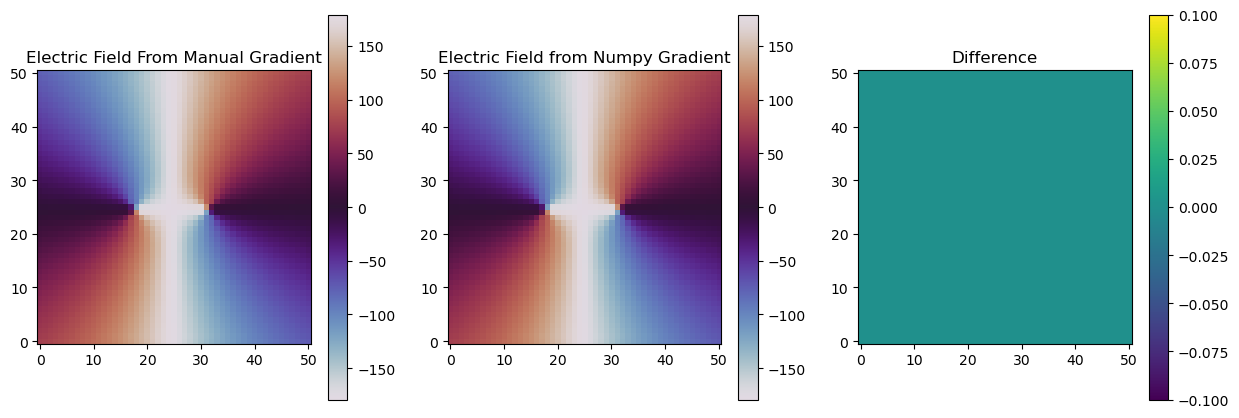

In [65]:
dip = dipole_potential(14)
Ex1, Ey1 = m_gradient(dip, 1)
Exn, Eyn = np.gradient(dip)

# Calculate angle    
angle1 = np.degrees(np.arctan2(-Ey1, -Ex1))
angle2 = np.degrees(np.arctan2(-Exn, -Eyn))
diff = angle1-angle2

fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Plot angle1
g1 = axs[0].imshow(angle1, cmap='twilight', origin='lower')
axs[0].set_title('Electric Field From Manual Gradient')
fig.colorbar(g1, ax=axs[0])

# Plot angle2
g2 = axs[1].imshow(angle2, cmap='twilight', origin='lower')
axs[1].set_title('Electric Field from Numpy Gradient')
fig.colorbar(g2, ax=axs[1])

# Plot difference
g3 = axs[2].imshow(diff, origin='lower')
axs[2].set_title('Difference')
fig.colorbar(g3, ax=axs[2])

plt.show()


This scheme yields the same output as `np.gradient`, with negligible difference.

# Problem (2)

New function to calculate the electric field exactly.

In [66]:
def e_field(charges, xgrid, ygrid):
    Ex = np.zeros_like(xgrid) 
    Ey = np.zeros_like(ygrid) 

    for charge in charges:
        dx = xgrid - charge.x
        dy = ygrid - charge.y
        r = np.sqrt(dx**2 + dy**2)

        
        # Calculate the contribution to the electric field
        Ex += charge.q * dx / r**3
        Ey += charge.q * dy / r**3
        

    return Ex, Ey


Create a function to generate a dipole, call the electric field function, and calculate angle between $E_x$ and $E_y$.

In [67]:
def dip_field(n):
    # Create dipole charges
    dip_charges = np.array([Charge(18, 25, 1), Charge(18 + n, 25, -1)])
    
    # Create 51 x 51 grid
    x = np.linspace(0, 51, 51)
    y = np.linspace(0, 51, 51)
    xgrid, ygrid = np.meshgrid(x, y)

    # Exactly calculate electric field 
    Ex, Ey = e_field(dip_charges, xgrid, ygrid)
    angle = np.degrees(np.arctan2(-Ey, -Ex))
    return Ex, Ey, angle

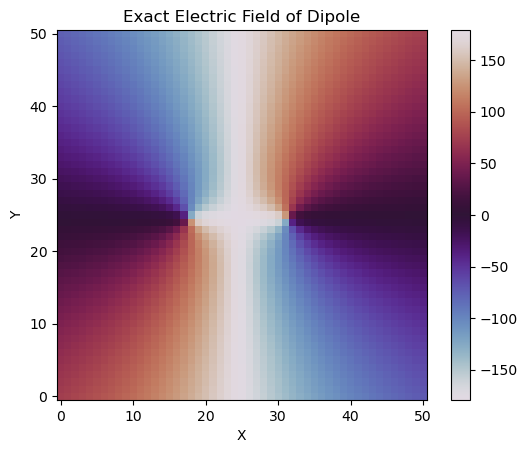

In [68]:
Ex2, Ey2, angle = dip_field(14)

# Plot
plt.imshow(angle, cmap='twilight', origin='lower')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exact Electric Field of Dipole')
plt.show()

This is the same as the electric field calculated from the gradient of the potential (in Q1). Calculating the errors between the exact electric field and the electric field found using the gradient: 

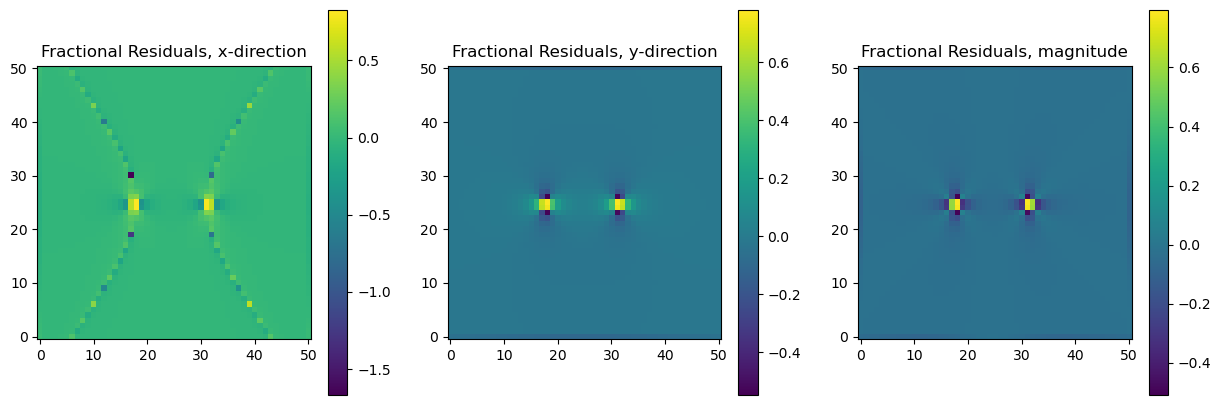

In [69]:
Errx, Erry = (Ex2-Ex1)/Ex2, (Ey2-Ey1)/Ey2
Errmag = (np.hypot(Ex2, Ey2) - np.hypot(Ex1, Ey1))/np.hypot(Ex2, Ey2)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Errx
im1 = axs[0].imshow(Errx, origin='lower')
axs[0].set_title('Fractional Residuals, x-direction')
fig.colorbar(im1, ax=axs[0])

# Plot Erry
im2 = axs[1].imshow(Erry, origin='lower')
axs[1].set_title('Fractional Residuals, y-direction')
fig.colorbar(im2, ax=axs[1])

# Plot Errmag
im3 = axs[2].imshow(Errmag, origin='lower')
axs[2].set_title('Fractional Residuals, magnitude')
fig.colorbar(im3, ax=axs[2])

plt.show()


Compared to machine precision, the fractional error is significant; it is on the order of $10^{-1}$ compared to machine precision which is on the order of $10^{-16}$.

# Problem (3)

## (A)

Create a function to calculate electric field at a point:

In [70]:
def e_fieldp(charges, x, y):
    Ex = 0
    Ey = 0
    for charge in charges:
        dx = x - charge.x
        dy = y - charge.y
        r = np.sqrt(dx**2 + dy**2)

        # Calculate the contribution to the electric field
        Ex += charge.q * dx / r**3
        Ey += charge.q * dy / r**3

    return Ex, Ey


Creating a function for drawing field lines given some arrangement of charges:

In [71]:
def field_lines(charges, xi, yi, lim, h=0.1):
    x, y = xi, yi
    trajx, trajy = np.array([]), np.array([])
    
    # Only inputting dipoles -> second charge must be the negative one
    neg_charge = charges[1]
    

    while True:
        Ex, Ey = e_fieldp(charges, x, y)

        Emag = np.hypot(Ex, Ey)
        x += h * Ex/Emag # Normalize electric field strength for uniform step size
        y += h * Ey/Emag

        dxneg, dyneg = neg_charge.x - x, neg_charge.y - y 
        R = np.hypot(dxneg, dyneg) # Distance from point to negative charge

        # Stop loop if field-lines are within 0.5 of the negative charge
        if R < 0.5: 
            break

        trajx = np.append(trajx, x)
        trajy = np.append(trajy, y) 

        # Wrap around to the other side once field-lines reach edge of box
        if x < -lim or x > lim or y < -lim or y > lim:
            x = -x # Charges are symmetric about y-axis -> field lines going to left are mirror of field lines going to right

    return trajx, trajy


Create plotting function to avoid redundancy in code:

In [72]:
def mplot(dip_pos, lim):
    _, ax = plt.subplots(1,1)
    msize = 100

    # Plot points where dipole charges are located
    ax.scatter(dip_pos[0, 0], dip_pos[1, 0],s=msize, marker='o', color='blue', zorder=2)
    ax.scatter(dip_pos[0, 1], dip_pos[1, 1],s=msize, marker='o', color='red', zorder=2)

    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    ax.set_xticks(np.arange(-lim, lim, 1), minor=True)
    ax.set_yticks(np.arange(-lim, lim, 1), minor=True)
    ax.grid(which='both')
    ax.set_axisbelow(True)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Field Lines of Dipole')
    
    return ax

Launch a line directly towards the negative charge from the positive charge:

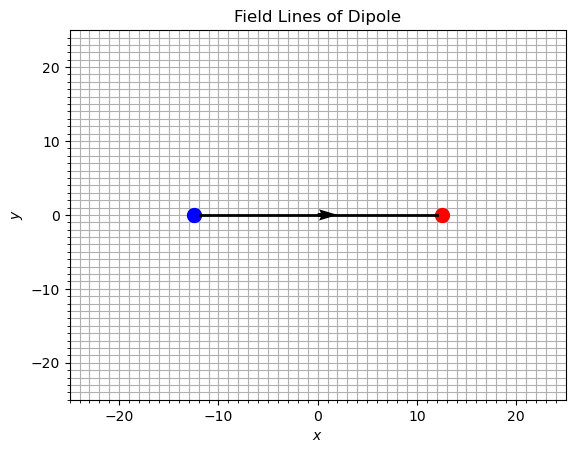

In [73]:
lim = 25 # Set limits of plot
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) # Set dipole position (horizontally symmetric about origin)
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) # Array of charges

trajx1, trajy1 = field_lines(dipole, dip_pos[0, 0]+0.5, 0, lim)
ax1 = mplot(dip_pos, lim)
ax1.plot(trajx1, trajy1, "k-", linewidth=2)

# Create arrow halfway pointing in +x direction
ax1.quiver(trajx1[int(len(trajx1)/2-1)], trajy1[int(len(trajy1)/2-1)], trajx1[int(len(trajx1)/2-1)]+0.2, 0, scale=1.0, scale_units='inches')

plt.show()


## (B)

Launch a line from negative charge:

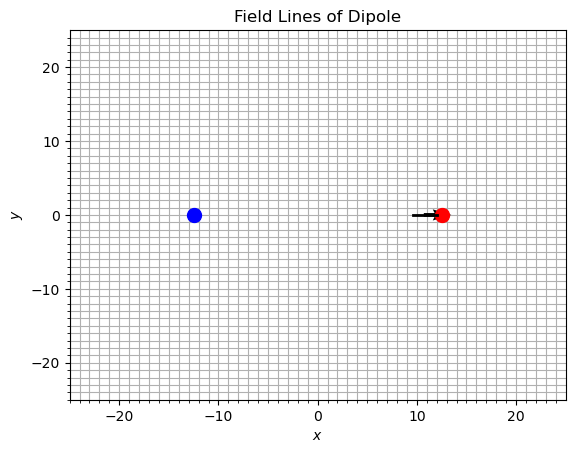

In [74]:
trajx1, trajy1 = field_lines(dipole, dip_pos[0, 1]-3, dip_pos[1,1], lim)
ax2 = mplot(dip_pos, lim)
ax2.plot(trajx1, trajy1, "k-", linewidth=2)

# Create arrow pointing in +x direction
ax2.quiver(trajx1[int(len(trajx1)/2-1)], trajy1[int(len(trajy1)/2-1)], 1, 0)

plt.show()


## (C)

Launch a line from the positive charge perpendicular to dipole axis

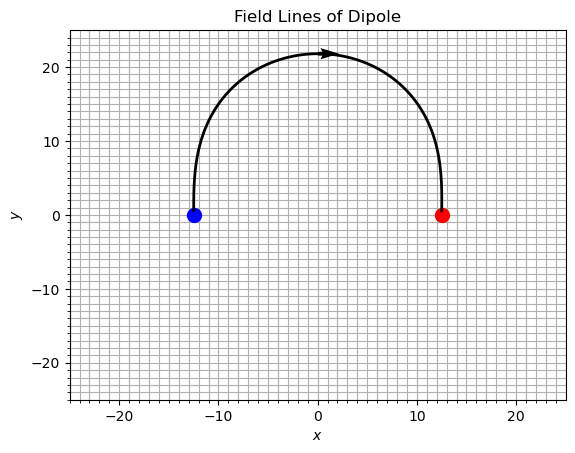

In [75]:
trajx1, trajy1 = field_lines(dipole, dip_pos[0, 0], dip_pos[1,0]+0.5, lim)

ax3 = mplot(dip_pos, lim)
ax3.plot(trajx1, trajy1, "k-", linewidth=2)

# Create arrow halfway pointing in +x direction
ax3.quiver(trajx1[int(len(trajx1)/2-1)], trajy1[int(len(trajy1)/2-1)], trajx1[int(len(trajx1)/2-1)] + 0.2, 0, scale=1.0, scale_units='inches')

plt.show()



## (D)

Field lines show the force a charged particle at rest would experience if placed at a certain point. An actual charged particle placed in an electric field will accelerate and quickly gain a non-zero velocity. It's motion will no longer be the same as that of a charged particle as rest. Thus, it will no longer follow the path traced out by the field-lines since it is no longer at rest. 

# Problem 4

Create a function to calculate $n$ equidistant points on a circle around a point. This is where the field-lines will start from.

In [76]:
def eq_points(n, radius, xc, yc):
    xr, yr = np.array([]), np.array([])
    for i in range(n):
        xr, yr = np.append(xr, xc + radius * np.cos((2*np.pi*i)/(n))), np.append(yr, yc + radius * np.sin((2*np.pi*i)/(n)))
    return xr, yr

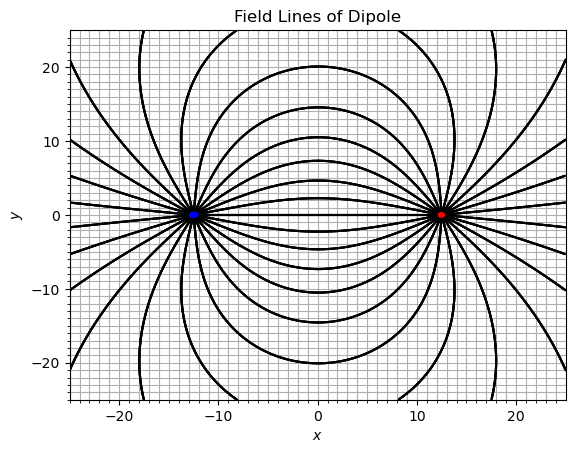

In [78]:
n = 25 # Number of field lines
xr, yr = eq_points(n, 0.5, -12.5, 0)

ax = mplot(dip_pos, lim)

# Remove discontinuity in graph when field-lines flip side
for i in range(n):
    trajxp, trajyp = field_lines(dipole, xr[i], yr[i], lim)
    for j in range(len(trajxp) - 1):
        if abs(trajxp[j + 1] - trajxp[j]) < lim / 2: # Ensure that difference between consecutive elements < box limits
            ax.plot(trajxp[j:j + 2], trajyp[j:j + 2], "k-")

